# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [24]:

df_descr = pd.read_csv('data/otp_description.csv', sep='\t', encoding='utf8')

In [25]:
df_descr.head(15)

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,AGE,возраст клиента
2,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
3,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
4,GENDER,"пол клиента (1- женщины, 0-мужчины)"
5,CHILD_TOTAL,количество детей клиента
6,DEPENDANTS,количество иждивенцев клиента
7,EDUCATION,образование
8,MARITAL_STATUS,семейное положение
9,GEN_INDUSTRY,отрасль работы клиента


Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [26]:
df_train = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')

In [27]:
df_train.shape

(15223, 52)

In [28]:
df_test = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')

In [29]:
df_test.shape

(14910, 52)

In [30]:
df_train.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,...,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,...,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,...,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,...,1,1,1,1,6,3,1,"1589,92333333333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,...,0,1,2,1,16,2,1,"1152,15",2230,NaN


## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [31]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'

In [32]:
df = df_test.append(df_train).reset_index(drop=True)

In [33]:
df.shape

(30133, 53)

### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 53 columns):
AGREEMENT_RK                  30133 non-null int64
TARGET                        30133 non-null int64
AGE                           30133 non-null int64
SOCSTATUS_WORK_FL             30133 non-null int64
SOCSTATUS_PENS_FL             30133 non-null int64
GENDER                        30133 non-null int64
CHILD_TOTAL                   30133 non-null int64
DEPENDANTS                    30133 non-null int64
EDUCATION                     30133 non-null object
MARITAL_STATUS                30133 non-null object
GEN_INDUSTRY                  27420 non-null object
GEN_TITLE                     27420 non-null object
ORG_TP_STATE                  27420 non-null object
ORG_TP_FCAPITAL               27425 non-null object
JOB_DIR                       27420 non-null object
FAMILY_INCOME                 30133 non-null object
PERSONAL_INCOME               30133 non-null object
REG_ADDRESS_PRO

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [35]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Среднее специальное', 'Среднее', 'Высшее', 'Ученая степень', 'Неоконченное высшее', 'Неполное среднее', 'Два и более высших образования'}


MARITAL_STATUS
{'Не состоял в браке', 'Гражданский брак', 'Вдовец/Вдова', 'Состою в браке', 'Разведен(а)'}


GEN_INDUSTRY
{nan, 'Недвижимость', 'Информационные технологии', 'Банк/Финансы', 'Сборочные производства', 'Энергетика', 'Подбор персонала', 'Сельское хозяйство', 'ЧОП/Детективная д-ть', 'Ресторанный бизнес/Общественное питание', 'Коммунальное хоз-во/Дорожные службы', 'Информационные услуги', 'Образование', 'Химия/Парфюмерия/Фармацевтика', 'Нефтегазовая промышленность', 'Туризм', 'Металлургия/Промышленность/Машиностроение', 'Торговля', 'Наука', 'Салоны красоты и здоровья', 'Здравоохранение', 'Строительство', 'Развлечения/Искусство', 'Маркетинг', 'Государственная служба', 'Управляющая компания', 'СМИ/Реклама/PR-агенства', 'Юридические услуги/нотариальные услуги', 'Другие сферы', 'Транспорт', 'Логистика', 'Страхование'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [36]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')

0         7000.0
1         4100.0
2        40000.0
3        20000.0
4        17000.0
5         7000.0
6        10000.0
7         7500.0
8         9000.0
9         4000.0
10       15000.0
11       12000.0
12        8000.0
13       20000.0
14       18500.0
15       14000.0
16        6000.0
17        9000.0
18        5000.0
19       15000.0
20        6100.0
21       22180.0
22        9000.0
23        8700.0
24        7000.0
25        6000.0
26       15000.0
27       12000.0
28       11000.0
29        8000.0
          ...   
30103    12000.0
30104    10000.0
30105    10000.0
30106     8000.0
30107    11000.0
30108     7000.0
30109    10000.0
30110     8000.0
30111    25000.0
30112    10000.0
30113    12000.0
30114     7000.0
30115    12000.0
30116    14500.0
30117    12000.0
30118     8000.0
30119     7000.0
30120    10000.0
30121    10000.0
30122    10000.0
30123    15000.0
30124     8100.0
30125     9500.0
30126    13000.0
30127    10000.0
30128    12000.0
30129    10000.0
30130     6000

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

In [53]:
#Исходя из df.info() и того, что работа ведется с числами, обращаем внимания на пропуски в стобцах WORK_TIME 
#(есть 27416 значений из 30133), 
#в столбцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT нет пропусков

df = df[~df['WORK_TIME'].isnull()] #удаляем пропуски


In [52]:
df.shape

(27416, 53)

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

In [39]:
#Категорийные признаки иммет тип object
#Нас скорее всего заинтересуют: EDUCATION, MARITAL_STATUS, FAMILY_INCOME, REGION_NM, остальные, например 
#почтовые адреса и индексы, можно заменить регионом или убрать, как не нужные в данной задаче

#Интересующие категорийные признаки мы разбиваем на столбцы и проставляем 0 или 1

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [40]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    #Удаляло идентификатор AGREEMENT_RK
    df_output = df_output.drop('AGREEMENT_RK', axis = 1)
    
    #Избавлялась от проблем
    df_output['PERSONAL_INCOME'] = df_output['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['CREDIT'] = df_output['CREDIT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['FST_PAYMENT'] = df_output['FST_PAYMENT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['LOAN_AVG_DLQ_AMT'] = df_output['LOAN_AVG_DLQ_AMT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['LOAN_MAX_DLQ_AMT'] = df_output['LOAN_MAX_DLQ_AMT'].map(lambda x: x.replace(',', '.')).astype('float')    
    
    #убираем не нужные столбцы
    df_output = df_output.drop(['FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL','GEN_INDUSTRY',
                    'GEN_TITLE','ORG_TP_STATE','ORG_TP_FCAPITAL','JOB_DIR','REG_ADDRESS_PROVINCE',
                    'FACT_ADDRESS_PROVINCE','POSTAL_ADDRESS_PROVINCE','TP_PROVINCE','DL_DOCUMENT_FL'], axis = 1)
    
    #в столбец REGION_NM вместо nan ставим REGION_Noname
    df_output['REGION_NM'] = df_output['REGION_NM'].fillna('REGION_Noname')
    
    #во времени работы есть выбросы. Ставим фильтр и заменяем некорректные данные на медиану
    WORK_TIME_median = df[df['WORK_TIME']<1000]['WORK_TIME'].median(skipna=True)
    df_output['WORK_TIME'] = df_output['WORK_TIME'].map(lambda x: x if x<1000 else WORK_TIME_median )
    
    #в описании указано что 'количество уже утилизированных карт' ( если пусто заполняем 0) '
    df_output['PREVIOUS_CARD_NUM_UTILIZED'] = df_output['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0)
    
    #разбиваем категориальные признаки на 0 и 1
    object_columns = ['EDUCATION', 'MARITAL_STATUS', 'FAMILY_INCOME', 'REGION_NM']
    df_output = pd.get_dummies(df_output, columns=object_columns)
    
    return df_output

In [42]:
df_preproc = df.pipe(preproc_data)

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [43]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27416 entries, 0 to 30132
Data columns (total 64 columns):
TARGET                                      27416 non-null int64
AGE                                         27416 non-null int64
SOCSTATUS_WORK_FL                           27416 non-null int64
SOCSTATUS_PENS_FL                           27416 non-null int64
GENDER                                      27416 non-null int64
CHILD_TOTAL                                 27416 non-null int64
DEPENDANTS                                  27416 non-null int64
PERSONAL_INCOME                             27416 non-null float64
REG_FACT_FL                                 27416 non-null int64
FACT_POST_FL                                27416 non-null int64
REG_POST_FL                                 27416 non-null int64
REG_FACT_POST_FL                            27416 non-null int64
REG_FACT_POST_TP_FL                         27416 non-null int64
FL_PRESENCE_FL                              

#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [44]:
#создаем массив ответов для train
df_y_train = list(df_train_preproc['TARGET'])

#создаем массив фич для train
df_x_train = df_train_preproc.drop(['TARGET'], axis = 1)

#создаем массив ответов для test
df_y_test = list(df_test_preproc['TARGET'])

#создаем массив фич для test
df_x_test = df_test_preproc.drop(['TARGET'], axis = 1)

print('train ', df_x_train.shape)
print('test ',df_x_test.shape)

train  (13855, 62)
test  (13561, 62)


In [45]:
from sklearn.cross_validation import train_test_split

#разбиваем train на обучение 67% и проерку 33%
X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (9282, 62)
X_test  (4573, 62)


/Users/test/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Задание 5. Обучение и оценка качества разных моделей

In [46]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
# Постепенно мы узнаем, что они делают а сейчас учимся понимать какой работает качественнее
#     fit, 
#     predict, 
#     predict_proba
# импортируем модели машинного обучения
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  

#импортируем метрики
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve


dict_model = {}
# Повторяем код обучения и предсказывания, но обучаем на одном куске, а предсказываем на другом

model1 = LogisticRegression()                     # инициализируем модель
model1.fit(X_train, y_train)                      # обучаем модель
predict = model1.predict(X_test)                      # делаем предсказание

#создаем массив метрик, но не выводим его
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]

#выводим качетво предсказанной модели
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')


from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier() 
model2.fit(X_train, y_train) 
predict = model2.predict(X_test) 
dict_model['DecisionTreeClassifier'] = [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')


from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)  
predict = model3.predict(X_test)
dict_model ['RandomForestClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> RandomForestClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

          0       0.88      1.00      0.93      4006
          1       0.00      0.00      0.00       567

avg / total       0.77      0.88      0.82      4573
 

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.88      0.86      0.87      4006
          1       0.15      0.17      0.16       567

avg / total       0.79      0.77      0.78      4573
 

########## >>> RandomForestClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.88      0.99      0.93      4006
          1       0.21      0.01      0.02       567

avg / total       0.79      0.87      0.82      4573
 



<Figure size 1080x1080 with 0 Axes>

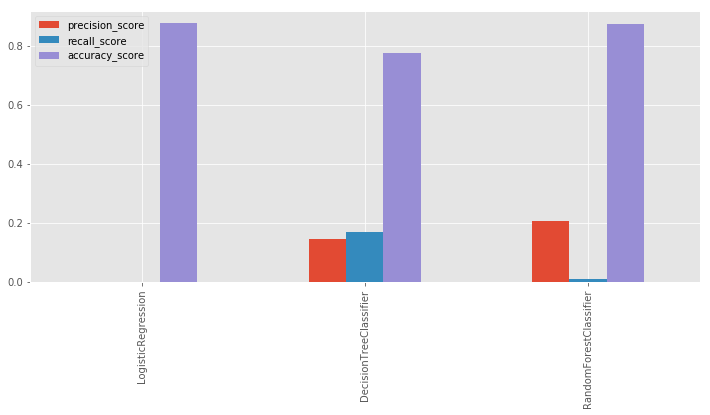

In [47]:
# выводим датафрейм с метриками

df_model = pd.DataFrame(dict_model).T
df_model.columns = ['precision_score','recall_score','accuracy_score']

# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает
plt.figure(figsize=(15, 15))
df_model.plot(kind='bar', legend=True)

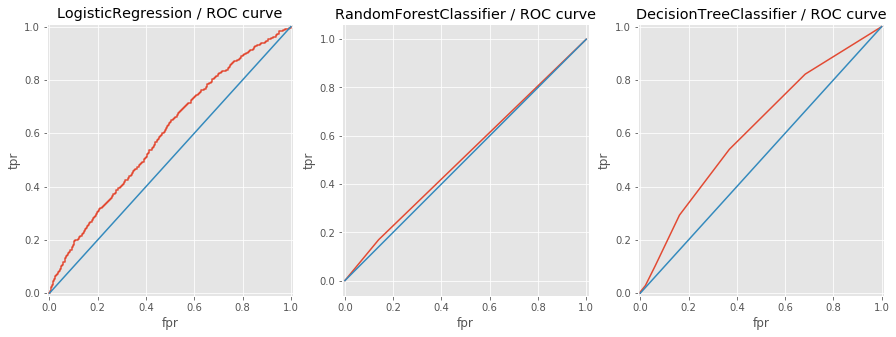

In [48]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

plt.figure(figsize=(15, 5))

#subplot 1
plt.subplot(131)
predict_proba1 = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 2
plt.subplot(132)
predict_proba2 = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('RandomForestClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 3
plt.subplot(133)
predict_proba3 = model3.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [49]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc
cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3,df_x_train,df_y_train,scoring='roc_auc', cv=10)
print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,'\nModel 1. LogisticRegression\t{:.2f}\nModel 2. RandomForestClassifier\t{:.2f}\nModel 3. DecisionTreeClassifier\t{:.2f} '
      .format( (sum(cross1) / float(len(cross1))),(sum(cross2) / float(len(cross2))),(sum(cross3) / float(len(cross3))) ) )

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. LogisticRegression	0.61
Model 2. RandomForestClassifier	0.53
Model 3. DecisionTreeClassifier	0.59 


In [50]:
# Взять лучшую модель и сделать предсказания (с вероятностями (!!!)) для test выборки

predict = model1.predict(df_x_test)


########## >>> LogisticRegression for Test <<< ########## 
              precision    recall  f1-score   support

          0       0.87      1.00      0.93     11845
          1       0.18      0.00      0.00      1716

avg / total       0.79      0.87      0.81     13561
 

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. LogisticRegression	0.60



(-0.01, 1.01)

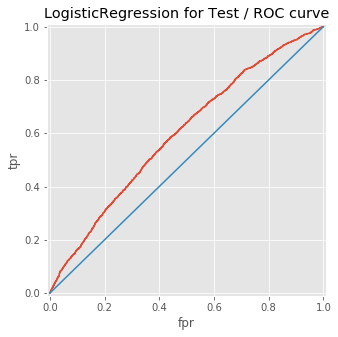

In [51]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

print('#'*10,'>>> LogisticRegression for Test <<<','#'*10,'\n',classification_report(df_y_test, predict),'\n')

cross1 = cross_val_score(model1,df_x_test,df_y_test,scoring='roc_auc', cv=10)
print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,'\nModel 1. LogisticRegression\t{:.2f}\n'.format( (sum(cross1) / float(len(cross1))) ) )


plt.figure(figsize=(5, 5))
predict_proba1 = model1.predict_proba(df_x_test)
fpr, tpr, thresholds = roc_curve(df_y_test, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression for Test / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

### Больше обязательных заданий нет, но ниже вы можете провести исследование, поиграться с данными
### Это возможность написать код, который я посмотрю и в случае чего откомметирую. ;)
### Это не оценивается и остается на ваше усмотрение. Просто дополнительная возможность

In [1]:
### Вы в коде мы удалили пропуски в столбце 'WORK_TIME'
# сейчас посмотрим как изменятся метрики, графики и roc_auc если пропуски заменить медианой


In [54]:
df_descr_1 = pd.read_csv('data/otp_description.csv', sep='\t', encoding='utf8')
df_descr_1.head(5)

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,AGE,возраст клиента
2,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
3,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
4,GENDER,"пол клиента (1- женщины, 0-мужчины)"


In [55]:
df_train_1 = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')
df_train_1.shape

(15223, 52)

In [56]:
df_test_1 = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')
df_test_1.shape

(14910, 52)

In [62]:
df_train_1.loc[:, 'sample'] = 'train'
df_test_1.loc[:, 'sample'] = 'test'

df_1 = df_test_1.append(df_train_1).reset_index(drop=True)

df_1.shape #пока что с пропусками

(30133, 53)

In [59]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    #Удаляло идентификатор AGREEMENT_RK
    df_output = df_output.drop('AGREEMENT_RK', axis = 1)
    
    #Избавлялась от проблем
    df_output['PERSONAL_INCOME'] = df_output['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['CREDIT'] = df_output['CREDIT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['FST_PAYMENT'] = df_output['FST_PAYMENT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['LOAN_AVG_DLQ_AMT'] = df_output['LOAN_AVG_DLQ_AMT'].map(lambda x: x.replace(',', '.')).astype('float')
    df_output['LOAN_MAX_DLQ_AMT'] = df_output['LOAN_MAX_DLQ_AMT'].map(lambda x: x.replace(',', '.')).astype('float')    
    
    #убираем не нужные столбцы
    df_output = df_output.drop(['FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL','GEN_INDUSTRY',
                    'GEN_TITLE','ORG_TP_STATE','ORG_TP_FCAPITAL','JOB_DIR','REG_ADDRESS_PROVINCE',
                    'FACT_ADDRESS_PROVINCE','POSTAL_ADDRESS_PROVINCE','TP_PROVINCE','DL_DOCUMENT_FL'], axis = 1)
    
    #в столбец REGION_NM вместо nan ставим REGION_Noname
    df_output['REGION_NM'] = df_output['REGION_NM'].fillna('REGION_Noname')
    
    #во времени работы есть выбросы. Ставим фильтр и заменяем некорректные данные на медиану
    WORK_TIME_median = df[df['WORK_TIME']<1000]['WORK_TIME'].median(skipna=True)
    df_output['WORK_TIME'] = df_output['WORK_TIME'].map(lambda x: x if x<1000 else WORK_TIME_median )
    
    #в описании указано что 'количество уже утилизированных карт' ( если пусто заполняем 0) '
    df_output['PREVIOUS_CARD_NUM_UTILIZED'] = df_output['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0)
    
    #разбиваем категориальные признаки на 0 и 1
    object_columns = ['EDUCATION', 'MARITAL_STATUS', 'FAMILY_INCOME', 'REGION_NM']
    df_output = pd.get_dummies(df_output, columns=object_columns)
    
    return df_output

In [63]:
df_preproc_1 = df_1.pipe(preproc_data)

df_train_preproc_1 = df_preproc_1.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc_1 = df_preproc_1.query('sample == "test"').drop(['sample'], axis=1)

In [64]:
df_preproc_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 64 columns):
TARGET                                      30133 non-null int64
AGE                                         30133 non-null int64
SOCSTATUS_WORK_FL                           30133 non-null int64
SOCSTATUS_PENS_FL                           30133 non-null int64
GENDER                                      30133 non-null int64
CHILD_TOTAL                                 30133 non-null int64
DEPENDANTS                                  30133 non-null int64
PERSONAL_INCOME                             30133 non-null float64
REG_FACT_FL                                 30133 non-null int64
FACT_POST_FL                                30133 non-null int64
REG_POST_FL                                 30133 non-null int64
REG_FACT_POST_FL                            30133 non-null int64
REG_FACT_POST_TP_FL                         30133 non-null int64
FL_PRESENCE_FL                              

In [65]:
#создаем массив ответов для train
df_y_train_1 = list(df_train_preproc_1['TARGET'])

#создаем массив фич для train
df_x_train_1 = df_train_preproc_1.drop(['TARGET'], axis = 1)

#создаем массив ответов для test
df_y_test_1 = list(df_test_preproc_1['TARGET'])

#создаем массив фич для test
df_x_test_1 = df_test_preproc_1.drop(['TARGET'], axis = 1)

print('train ', df_x_train_1.shape)
print('test ',df_x_test_1.shape)

train  (15223, 62)
test  (14910, 62)


In [66]:
from sklearn.cross_validation import train_test_split

#разбиваем train на обучение 67% и проерку 33%
X_train_1, X_test_1, y_train_1, y_1 = train_test_split(df_x_train_1, df_y_train_1, test_size=0.33, random_state=42)
print('X_train_1 ', X_train_1.shape)
print('X_test_1 ',X_test_1.shape)

X_train_1  (10199, 62)
X_test_1  (5024, 62)


In [71]:
dict_model = {}
# Повторяем код обучения и предсказывания, но обучаем на одном куске, а предсказываем на другом

model1 = LogisticRegression()                     # инициализируем модель
model1.fit(X_train_1, y_train_1)                      # обучаем модель
predict = model1.predict(X_test_1)                      # делаем предсказание

#создаем массив метрик, но не выводим его
dict_model ['LogisticRegression']= [precision_score(y_1, predict), recall_score(y_1, predict), accuracy_score(y_1, predict)]

#выводим качетво предсказанной модели
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y_1, predict),'\n')


from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier() 
model2.fit(X_train_1, y_train_1) 
predict = model2.predict(X_test_1) 
dict_model['DecisionTreeClassifier'] = [precision_score(y_1, predict), recall_score(y_1, predict), accuracy_score(y_1, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y_1, predict),'\n')


from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(X_train_1, y_train_1)  
predict = model3.predict(X_test_1)
dict_model ['RandomForestClassifier']= [precision_score(y_1, predict), recall_score(y_1, predict), accuracy_score(y_1, predict)]
print('#'*10,'>>> RandomForestClassifier <<<','#'*10,'\n',classification_report(y_1, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

          0       0.88      1.00      0.94      4414
          1       0.43      0.00      0.01       610

avg / total       0.82      0.88      0.82      5024
 

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.89      0.86      0.87      4414
          1       0.16      0.19      0.18       610

avg / total       0.80      0.78      0.79      5024
 

########## >>> RandomForestClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.88      1.00      0.93      4414
          1       0.10      0.00      0.01       610

avg / total       0.78      0.88      0.82      5024
 



<Figure size 1080x1080 with 0 Axes>

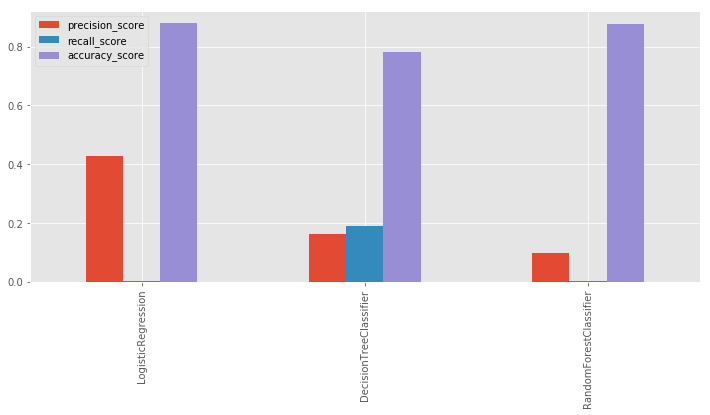

In [72]:
# выводим датафрейм с метриками

df_model = pd.DataFrame(dict_model).T
df_model.columns = ['precision_score','recall_score','accuracy_score']

# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает
plt.figure(figsize=(15, 15))
df_model.plot(kind='bar', legend=True)

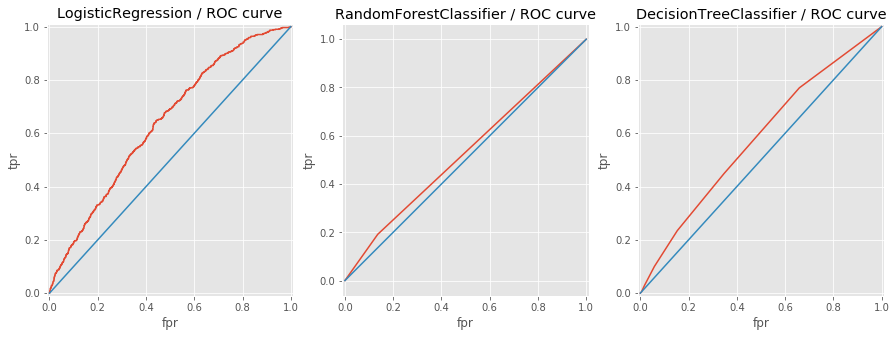

In [73]:
plt.figure(figsize=(15, 5))

#subplot 1
plt.subplot(131)
predict_proba1 = model1.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(y_1, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 2
plt.subplot(132)
predict_proba2 = model2.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(y_1, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('RandomForestClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 3
plt.subplot(133)
predict_proba3 = model3.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(y_1, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [74]:
cross1 = cross_val_score(model1,df_x_train_1,df_y_train_1,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train_1,df_y_train_1,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3,df_x_train_1,df_y_train_1,scoring='roc_auc', cv=10)
print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,'\nModel 1. LogisticRegression\t{:.2f}\nModel 2. RandomForestClassifier\t{:.2f}\nModel 3. DecisionTreeClassifier\t{:.2f} '
      .format( (sum(cross1) / float(len(cross1))),(sum(cross2) / float(len(cross2))),(sum(cross3) / float(len(cross3))) ) )

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. LogisticRegression	0.63
Model 2. RandomForestClassifier	0.53
Model 3. DecisionTreeClassifier	0.59 


In [75]:
predict = model1.predict(df_x_test_1)

########## >>> LogisticRegression for Test <<< ########## 
              precision    recall  f1-score   support

          0       0.88      1.00      0.94     13160
          1       0.10      0.00      0.00      1750

avg / total       0.79      0.88      0.83     14910
 

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. LogisticRegression	0.63



(-0.01, 1.01)

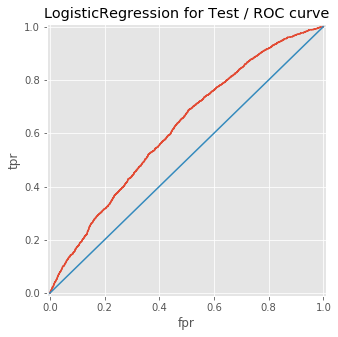

In [76]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

print('#'*10,'>>> LogisticRegression for Test <<<','#'*10,'\n',classification_report(df_y_test_1, predict),'\n')

cross1 = cross_val_score(model1,df_x_test_1,df_y_test_1,scoring='roc_auc', cv=10)
print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,'\nModel 1. LogisticRegression\t{:.2f}\n'.format( (sum(cross1) / float(len(cross1))) ) )


plt.figure(figsize=(5, 5))
predict_proba1 = model1.predict_proba(df_x_test_1)
fpr, tpr, thresholds = roc_curve(df_y_test_1, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression for Test / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))